## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole, molal, molar,grams,milliliter,kilogram
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm


/tmp/ipykernel_7172/3824394281.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*              

## Loading data and creating atom group of ions

In [107]:
u = mda.Universe('md.gro', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname SOD CLA')

u2 = mda.Universe('md2m.gro', 'md2m.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname SOD CLA')

u2l = mda.Universe('md2ml.gro', 'md2ml.xtc')
u2l.transfer_to_memory()
ions2l= u2l.select_atoms('resname SOD CLA')

u3 = mda.Universe('md3m.gro', 'md3m.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname SOD CLA')

u3l = mda.Universe('md3ml.gro', 'md3ml.xtc')
u3l.transfer_to_memory()
ions3l= u3l.select_atoms('resname SOD CLA')

In [23]:
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant


def osmotic_ideal(molarity, vant_hoff:int=2, T=300*kelvin):
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    print(f"Osmotic Pressure Ideal:", osm_press_ideal)
    return osm_press_ideal

oi2=osmotic_ideal(1.923*(mole/litre),2,300*kelvin)
oi3=osmotic_ideal(2.823*(mole/litre),2,300*kelvin)

Osmotic Pressure Ideal: 95.93226968825209 bar
Osmotic Pressure Ideal: 140.83036782627957 bar


## Function for calculating osmotic values:

In [65]:
def SPW_analysis(u, ions, molal_conc):

## defining variables
    box_size = u.dimensions[:3] * angstrom
    wall1=box_size[2]/2-24*angstrom
    wall2=box_size[2]/2+24*angstrom
    R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

    box_x = box_size[0]
    box_y = box_size[1]

    A_box = (box_x * box_y)

    dim_mem = wall2-wall1
    V_mem = A_box * dim_mem
    #print(V_mem)
    

    if molal_conc == 1:
        print(f'--Data for {molal_conc} m concentration--')
        n_part = 65
        nacl_dens=1.03621*(grams/milliliter)

    elif molal_conc == 2:
        print(f'--Data for {molal_conc} m concentration--')
        n_part = 128
        nacl_dens=1.07227*(grams/milliliter)
    elif molal_conc == 3:
        print(f'--Data for {molal_conc} m concentration--')
        n_part = 188
        nacl_dens=1.10579*(grams/milliliter)

    M = n_part / (V_mem * AVOGADRO_CONSTANT_NA)
    M = M.in_units_of(mole / litre)
    print(M)


    
## calculation of osmotic values

    def osmotic_values(mean_force_wall, molarity=M, vant_hoff:int=2, T=300*kelvin, cross_sectional_area:Quantity=(wall1*wall2)):
        osm_press=mean_force_wall/cross_sectional_area
        osm_bar = osm_press.in_units_of(bar / mole)
        osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
        print(f"Osmotic Pressure Observed:", osm_bar)
        osm_press_ideal=vant_hoff*molarity*R*T
        osm_press_ideal=osm_press_ideal.in_units_of(bar)
        print(f"Osmotic Pressure Ideal:", osm_press_ideal)
        osm_coeff=osm_bar/osm_press_ideal
        print(f"Osmotic Coefficient:", osm_coeff)
        op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
        print(f"Osmotic Pressure Error:", op_error)
        return osm_bar,osm_coeff
    
    def osmotic_values_noprint(mean_force_wall, molarity=M, vant_hoff:int=2, T=300*kelvin, cross_sectional_area:Quantity=(wall1*wall2)):
        osm_press=mean_force_wall/cross_sectional_area
        osm_bar = osm_press.in_units_of(bar / mole)
        osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
        osm_press_ideal=vant_hoff*molarity*R*T
        osm_press_ideal=osm_press_ideal.in_units_of(bar)
        osm_coeff=osm_bar/osm_press_ideal
        op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
        return osm_bar,osm_coeff



## calculation of mean force
    
    def calculate_net_force(z_values : np.ndarray[float], zwall : float, k : float) -> float:
        return k * abs(z_values - zwall).sum()

    k_nm = 4184 * kilojoule_per_mole / nanometer**2
    k = k_nm.in_units_of(kilojoule_per_mole / angstrom**2)

    walls_z_pos = np.array([48, 96]) * angstrom
    forces_at_ts = {
        48 : [],
        96 : []
    }

    for _ in u.trajectory:
        ions_z = ions.positions[:,2]*angstrom
        force_48 = calculate_net_force(
            z_values=ions_z[ions_z < wall1],
            zwall=wall1,
            k=k
        )
        forces_at_ts[48].append(force_48)

        force_96 = calculate_net_force(
            z_values=ions_z[ions_z > wall2],
            zwall=wall2,
            k=k
        )
        forces_at_ts[96].append(force_96)

    mean_forces = {
        abs_wall_z : sum(force_list, start=0*(kilojoule_per_mole / angstrom)) / len(u.trajectory)
            for abs_wall_z, force_list in forces_at_ts.items()
    }

    print('mean forces =', mean_forces)


## calling calculation of osmotic values
    
    for wall_z_val, mF in mean_forces.items():
        print(wall_z_val)
        o = osmotic_values(mF, molarity=M, cross_sectional_area=A_box)


    # print("Average between 2 walls: ")
    # av_mF=(mean_forces[48]+mean_forces[96])/2
    # o = osmotic_values(av_mF, molarity=M, cross_sectional_area=A_box)

## number of ions per z coordinate (both observed through the system and outside the walls)
    ions_at_48=[]
    ions_at_96=[]
    zpositions=[]

    for _ in u.trajectory:
        ions_z = ions.positions[:,2]*angstrom
        zpositions.append(ions_z)
        z_values48=ions_z[ions_z < wall1]
        z_values96=ions_z[ions_z > wall2]
        ions_at_48.append(z_values48)
        ions_at_96.append(z_values96)

    # plt.hist(ions_at_48,bins='auto',edgecolor='blue')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions outside of wall at 4.8 nm')
    # plt.axis([47, 48, 0, 2.5])
    # # Display the plot
    # plt.grid(True)
    # plt.show()

    # plt.hist(ions_at_96,bins='auto',edgecolor='red')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions outside of wall at 9.6 nm')
    # plt.axis([96, 97, 0, 2.5])
    # plt.grid(True)
    # plt.show()

    # plt.hist(zpositions,bins='auto',edgecolor='green')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions per z coordinate')
    # plt.grid(True)
    # plt.show()

## plotting force vs time

    list48=forces_at_ts[48]
    list96=forces_at_ts[96]
    f48=[]
    f96=[]
    time=[]
    for i,ts in enumerate(u.trajectory):
        time.append(u.trajectory.time)
        val48=list48[i]
        val96=list96[i]
        f48.append(val48.item())
        f96.append(val96.item())

    # plt.plot(time,f96, color='r', label='9.6 nm')
    # plt.plot(time,f48, color='g', label='4.8 nm')
    # plt.ylabel("Forces")
    # plt.xlabel("Time")
    # plt.title("Forces vs time")
    # plt.legend()
    # plt.show()


    print("----------------------------------------------------------------")

## calculation of autocorrelation function and plot of uncorrelated samples
    
    fts48=np.array(f48)
    fts96=np.array(f96)

    nskip=100
    t0, g, Neff_max = timeseries.detect_equilibration(fts48,nskip=nskip) # compute indices of uncorrelated timeseries
    fts48_equil = fts48[t0:]
    indices48 = timeseries.subsample_correlated_data(fts48_equil, g=g)
    fts48_s = fts48_equil[indices48]

    indt48=[]
    for i in indices48:
        indt48.append(time[i])

    print("---Wall 4.8 nm---")
    print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)
    #mean of full time series
    meanf48=np.mean(f48)
    meanf48=meanf48*kilojoule_per_mole/angstrom
    #stdev of the full timeseries devided by sqrt of the number of effective samples -1
    sterrf48=np.std(f48)/np.sqrt(len(indt48)-1)
    # squared_diff48 = (f48*kilojoule_per_mole/angstrom - meanf48) ** 2
    varf48 = sterrf48**2

    print(f"Mean = {meanf48}, std error = {sterrf48}, variance = {varf48}",'\n')

    # plt.plot(time,f48)
    # plt.scatter(indt48, fts48_s, color='m', marker='o')
    # plt.ylabel("Forces")
    # plt.xlabel("Time")
    # plt.title("Forces at 4.8 nm Wall")
    # plt.show()

    t0, g, Neff_max = timeseries.detect_equilibration(fts96,nskip=nskip) # compute indices of uncorrelated timeseries
    fts96_equil = fts96[t0:]
    indices96 = timeseries.subsample_correlated_data(fts96_equil, g=g)
    fts96_s = fts96_equil[indices96]

    indt96=[]
    for i in indices96:
        indt96.append(time[i])


    print("---Wall 9.6 nm---")
    #statistical values of t0 (time after equil), g (statistical efficiency/correlation time of equil data), Neff (# of eff samples)
    print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)
    #mean of full time series
    meanf96=np.mean(f96)
    meanf96=meanf96*mF.unit
    #stdev of the full timeseries devided by sqrt of the number of effective samples -1
    sterrf96=np.std(f96)/np.sqrt(len(indt96)-1)
    # squared_diff96 = (f96*kilojoule_per_mole/angstrom - meanf96) ** 2
    varf96 = sterrf96**2
    print(f"Mean = {meanf96}, std error = {sterrf96}, variance = {varf96}",'\n')

    # plt.plot(time, f96, c='g')
    # plt.scatter(indt96, fts96_s, color='m', marker='o')
    # plt.ylabel("Forces")
    # plt.xlabel("Time")
    # plt.title("Forces at 9.6 nm Wall")
    # plt.show()

    def comb_SEM(sem1,sem2,n1,n2):
        """
        Calculate the standard error of the mean for combined data.

        Args:
        sem1 (float): Standard error of the mean for the first set of data.
        sem2 (float): Standard error of the mean for the second set of data.
        n1 (int): Sample size of the first set of data.
        n2 (int): Sample size of the second set of data.

        Returns:
        float: The standard error of the mean for combined data.
        """
        combined_sem = np.sqrt((sem1**2 * (n1 - 1) + sem2**2 * (n2 - 1)) / (n1 + n2 - 2))
        return combined_sem
    
    print("---Statistical Analysis results---")
    #average between two walls
    statmeanF=(meanf48+meanf96)/2
    errvar=np.sqrt((varf48+varf96)/2)
    comberror=comb_SEM(sterrf48,sterrf96,len(indt48),len(indt96))
    print(f'Mean force between two walls: {statmeanF}')
    print(f'Mean std error between two walls: +/-{comberror} or {errvar}')
    
    errvar=errvar*(kilojoule_per_mole/angstrom)
    print("------------------------------------------------------------------------")

    print(f"FINAL STATISTICAL RESULTS FOR {molal_conc} MOLAL:")
    
    print("------------------------------------------------------------------------")   
    #calculation of osmotic values from statistical mean and std error
    osmval = osmotic_values_noprint(statmeanF, molarity=M, cross_sectional_area=A_box) 
    osmerr = osmotic_values_noprint(errvar, molarity=M, cross_sectional_area=A_box)

    print(f"Osmotic Pressure = {osmval[0]} +/- {osmerr[0]} \nOsmotic Coefficient = {osmval[1]} +/- {osmerr[1]}")

    return osmval[0],osmerr[0],M

In [105]:
m1=SPW_analysis(u,ions,1)
m1op=m1[0]
m1err=m1[1]
xc1=m1[2]


--Data for 1 m concentration--
0.9759751100106702 mol/L
mean forces = {48: Quantity(value=7.4354052386822325, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=6.302078656816847, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 53.588458676653325 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 1.1006445523117965
Osmotic Pressure Error: 10.064455231179643
96
Osmotic Pressure Observed: 45.42034641513391 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.9328810359629068
Osmotic Pressure Error: 6.711896403709323
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 0  g = 2.5294485  Neff_max = 396.1338
Mean = 7.4354052386822165 kJ/(A mol), std error = 0.4959716177125515, variance = 0.24598784557640532 

---Wall 9.6 nm---
t0 = 0  g = 1.4182512  Neff_max = 706.5039
Mean = 6.302078656816817 kJ/(A mol), std error = 0.3286609869085206, variance = 0.10801804431568274 

---Statistical Analysis result

In [70]:
m2=SPW_analysis(u2,ions2,2)
m2op=m2[0]
m2err=m2[1]
xc2=m2[2]


--Data for 2 m concentration--
1.9219202166363967 mol/L
mean forces = {48: Quantity(value=16.208342570820346, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=14.903531014883542, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 116.81677974385488 bar
Osmotic Pressure Ideal: 95.87840277777778 bar
Osmotic Coefficient: 1.2183847077073973
Osmotic Pressure Error: 21.838470770739722
96
Osmotic Pressure Observed: 107.41274083789585 bar
Osmotic Pressure Ideal: 95.87840277777778 bar
Osmotic Coefficient: 1.12030173350772
Osmotic Pressure Error: 12.030173350772012
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 0  g = 1.3539375  Neff_max = 740.0637
Mean = 16.208342570820296 kJ/(A mol), std error = 0.5255904021831026, variance = 0.2762452708669955 

---Wall 9.6 nm---
t0 = 0  g = 1.6412921  Neff_max = 610.4946
Mean = 14.903531014883555 kJ/(A mol), std error = 0.5383090195842464, variance = 0.28977660056575255 

---Statistical Analysis results

In [108]:
m2l=SPW_analysis(u2l,ions2l,2)
m2opl=m2l[0]
m2errl=m2l[1]
xc2l=m2l[2]

--Data for 2 m concentration--
1.9219202166363967 mol/L
mean forces = {48: Quantity(value=15.719248156665167, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=15.070309332759269, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 113.29177808482196 bar
Osmotic Pressure Ideal: 95.87840277777778 bar
Osmotic Coefficient: 1.1816193720644685
Osmotic Pressure Error: 18.161937206446837
96
Osmotic Pressure Observed: 108.61474566597825 bar
Osmotic Pressure Ideal: 95.87840277777778 bar
Osmotic Coefficient: 1.1328384966708316
Osmotic Pressure Error: 13.283849667083144
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 300  g = 1.3775529  Neff_max = 872.56177
Mean = 15.719248156665088 kJ/(A mol), std error = 0.47108830190362266, variance = 0.22192418819043874 

---Wall 9.6 nm---
t0 = 0  g = 1.7744586  Neff_max = 846.4553
Mean = 15.070309332759281 kJ/(A mol), std error = 0.4547572279854538, variance = 0.20680413640501402 

---Statistical Analysis 

In [106]:
m3=SPW_analysis(u3,ions3,3)
m3op=m3[0]
m3err=m3[1]
xc3=m3[2]

--Data for 3 m concentration--
2.8228203181847076 mol/L
mean forces = {48: Quantity(value=25.727778751704886, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=24.560821984412033, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 185.42526792018722 bar
Osmotic Pressure Ideal: 140.8214040798611 bar
Osmotic Coefficient: 1.316740655525852
Osmotic Pressure Error: 31.674065552585212
96
Osmotic Pressure Observed: 177.01477615893427 bar
Osmotic Pressure Ideal: 140.8214040798611 bar
Osmotic Coefficient: 1.2570161284469765
Osmotic Pressure Error: 25.701612844697646
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 300  g = 1.2721992  Neff_max = 551.8004
Mean = 25.727778751704843 kJ/(A mol), std error = 0.742711152520622, variance = 0.5516198560785107 

---Wall 9.6 nm---
t0 = 0  g = 1.4104737  Neff_max = 710.39966
Mean = 24.560821984412076 kJ/(A mol), std error = 0.6564790511337972, variance = 0.43096474457753076 

---Statistical Analysis resu

In [99]:
m3l=SPW_analysis(u3l,ions3l,3)
m3opl=m3l[0]
m3errl=m3l[1]
xc3l=m3l[2]

--Data for 3 m concentration--
2.8228203181847076 mol/L
mean forces = {48: Quantity(value=25.127709083633384, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=24.136804482639775, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 181.10044532097382 bar
Osmotic Pressure Ideal: 140.8214040798611 bar
Osmotic Coefficient: 1.2860292546030154
Osmotic Pressure Error: 28.60292546030154
96
Osmotic Pressure Observed: 173.95879687569516 bar
Osmotic Pressure Ideal: 140.8214040798611 bar
Osmotic Coefficient: 1.2353150290778347
Osmotic Pressure Error: 23.531502907783484
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 300  g = 1.2168076  Neff_max = 987.83075
Mean = 25.127709083633373 kJ/(A mol), std error = 0.5575998358335503, variance = 0.31091757692160227 

---Wall 9.6 nm---
t0 = 0  g = 1.3382856  Neff_max = 1122.3314
Mean = 24.13680448263983 kJ/(A mol), std error = 0.5103551846332482, variance = 0.2604624144820369 

---Statistical Analysis res

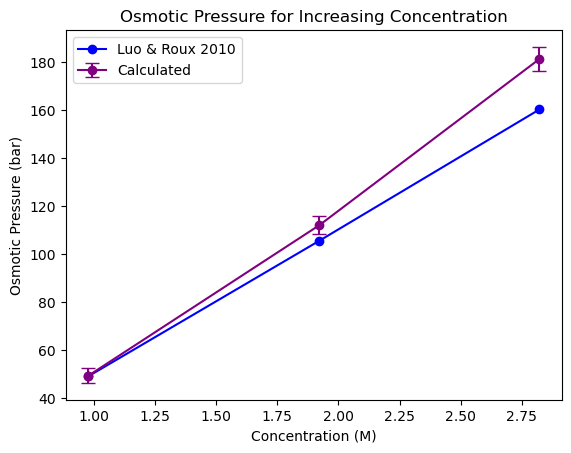

In [102]:
yOP=[m1op._value,m2op._value,m3op._value]
yerrs=[m1err._value,m2err._value,m3err._value]
yroux=[49.25814435639172,105.63795075630847,160.23739597931342]
xconc=[xc1._value,xc2._value,xc3._value]
plt.errorbar(xconc,yOP, yerr=yerrs, fmt='o', linestyle='-',color='purple', capsize=5, label='Calculated')
plt.plot(xconc,yroux, marker='o', linestyle='-',color='blue', label='Luo & Roux 2010')
plt.xlabel("Concentration (M)")
plt.ylabel("Osmotic Pressure (bar)")
plt.title('Osmotic Pressure for Increasing Concentration')
plt.legend()
plt.show()

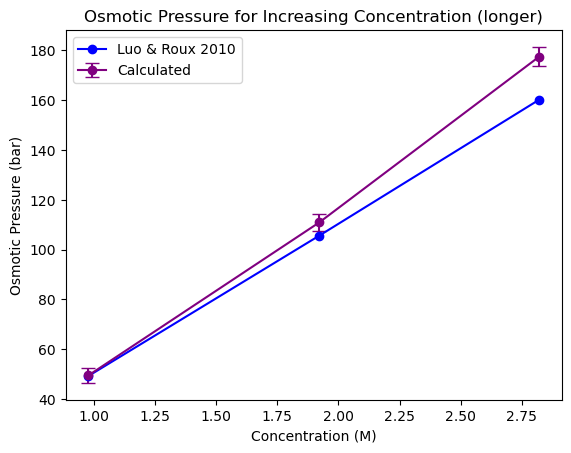

In [109]:
yOP=[m1op._value,m2opl._value,m3opl._value]
yerrs=[m1err._value,m2errl._value,m3errl._value]
yroux=[49.25814435639172,105.63795075630847,160.23739597931342]
xconc=[xc1._value,xc2._value,xc3._value]
plt.errorbar(xconc,yOP, yerr=yerrs, fmt='o', linestyle='-',color='purple', capsize=5, label='Calculated')
plt.plot(xconc,yroux, marker='o', linestyle='-',color='blue', label='Luo & Roux 2010')
plt.xlabel("Concentration (M)")
plt.ylabel("Osmotic Pressure (bar)")
plt.title('Osmotic Pressure for Increasing Concentration (longer)')
plt.legend()
plt.show()

### Density profiles using GROMACS

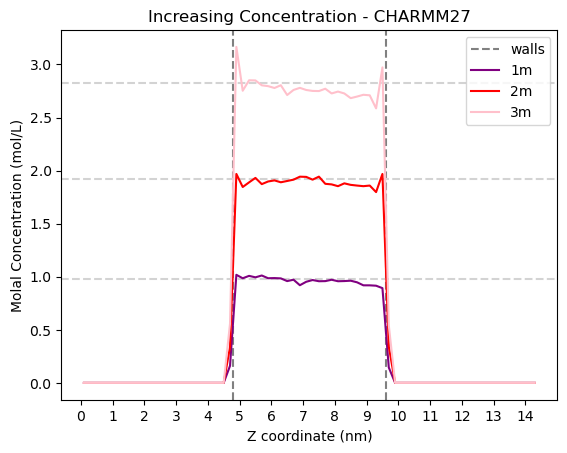

In [112]:
x,y = np.loadtxt("density_original.xvg",comments=["@", "#"],unpack=True)
y=(y/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y=y.in_units_of(mole/litre)/2
x1,y1 = np.loadtxt("dens_2m.xvg",comments=["@", "#"],unpack=True)
y1=(y1/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y1=y1.in_units_of(mole/litre)/2
x2,y2 = np.loadtxt("dens_3m.xvg",comments=["@", "#"],unpack=True)
y2=(y2/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y2=y2.in_units_of(mole/litre)/2
plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 0.98, color = 'lightgray', linestyle = 'dashed')
plt.axhline(y = 1.92, color = 'lightgray', linestyle = 'dashed')
plt.axhline(y = 2.83, color = 'lightgray', linestyle = 'dashed')
# plt.plot(zi_values, potential_energy_values, label=r'$V_{\mathrm{fb}}(z_i)$')
plt.plot(x,y, c='purple', label='1m')
plt.plot(x1,y1, c='red', label='2m')
plt.plot(x2,y2, c='pink', label='3m')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Molal Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1.0))
#plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.title('Increasing Concentration - CHARMM27')
plt.legend(loc='upper right')
plt.show()

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.16109969
 1.01844182 0.98586204 1.00853671 0.99467951 1.01195742 0.98621906
 0.98766373 0.98478269 0.95921869 0.97236186 0.92033717 0.95291695
 0.96929817 0.95795669 0.95903604 0.97182219 0.95795669 0.95958401
 0.96299642 0.94787721 0.91944048 0.91925782 0.91583711 0.89297979
 0.14525981 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ] mol/L


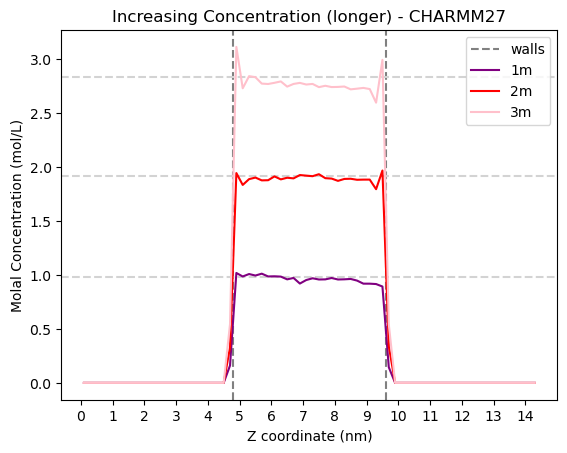

In [113]:
x,y = np.loadtxt("density_original.xvg",comments=["@", "#"],unpack=True)
y=(y/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y=y.in_units_of(mole/litre)/2
print(y)
x1,y1 = np.loadtxt("dens_2ml.xvg",comments=["@", "#"],unpack=True)
y1=(y1/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y1=y1.in_units_of(mole/litre)/2
x2,y2 = np.loadtxt("dens_3ml.xvg",comments=["@", "#"],unpack=True)
y2=(y2/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y2=y2.in_units_of(mole/litre)/2
plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 0.98, color = 'lightgray', linestyle = 'dashed')
plt.axhline(y = 1.92, color = 'lightgray', linestyle = 'dashed')
plt.axhline(y = 2.83, color = 'lightgray', linestyle = 'dashed')
# plt.plot(zi_values, potential_energy_values, label=r'$V_{\mathrm{fb}}(z_i)$')
plt.plot(x,y, c='purple', label='1m')
plt.plot(x1,y1, c='red', label='2m')
plt.plot(x2,y2, c='pink', label='3m')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Molal Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1.0))
#plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.title('Increasing Concentration (longer) - CHARMM27')
plt.legend(loc='upper right')
plt.show()

## Density profiles using MDanalysis

In [10]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [11]:
nbins1_old,ncounts1_old=density_profile(u1,ions,2)

NameError: name 'u1' is not defined

In [ ]:
def density_fprofile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    print(box,n_bins,bin_width)
    bins = np.linspace(0, box, num=n_bins)

    bin_atoms = universe.select_atoms(f'group ag', ag=ag)
    ion_indices = bin_atoms.indices
    nframes = len(universe.trajectory[::frameby])
    thisto = np.zeros([n_bins-1,nframes])
    ztraj = np.zeros([len(bin_atoms),nframes])    
    for i,ts in enumerate(tqdm(universe.trajectory[::frameby])):
        ztraj[:,i]= ts.positions[:,d][ion_indices]
        # calculate the histogram at each time point
        counts = np.histogram(ztraj[:,i],bins=bins)
        thisto[:,i] = counts[0]
    # we now have ztraj, get overall histogram
    counts = np.histogram(ztraj,bins=bins)
    return bins, counts[0], thisto

In [ ]:
newbins1,newcounts1,thisto1 = density_fprofile(u1,ions,bin_width=2.0,dim='z')

This new way of doing the counts is the same (it's the total counts, not counts per frame)

In [ ]:
newcounts1-ncounts1_old*1001

Now find the statistical inefficiencies of the histogram time series.

In [ ]:
ncorrs = len(thisto1[:,0])
corrs = np.zeros(ncorrs)
for i in range(ncorrs):
    tsum = np.sum(thisto1[i])
    if tsum !=0:
        corrs[i] = timeseries.statistical_inefficiency(thisto1[i])

In [ ]:
plt.plot(corrs)
plt.ylabel('statistical_efficiency')
plt.xlabel('bin_index')
plt.show()

Now get all three replicate ncounts

In [ ]:
nbins1,ncounts1,thisto1=density_fprofile(u1,ions1,2)
nbins2,ncounts2,thisto2=density_fprofile(u2,ions2,2)
nbins3,ncounts3,thisto3=density_fprofile(u3,ions3,2)

### Effect of changing number of bins

There are 130 total ions in the system. About 25 bins in the middle are occupied. There are 1001 simulation frames, so we would expect somewhere around 5200 counts in each bin.

We can treat this as a multinomial problem, with p_i at each point. If each frame is uncorrelated, the expectation at each point is 1001$\times$130$\times p_i$ = ncounts. So we can approximate each $p_i$ as ncounts/(1001$\times$130).

In [ ]:
# https://en.wikipedia.org/wiki/Multinomial_distribution    
# total observations
# assume there is a multinomial distribution 
# with a probability of each bin being the observed probability 

nions = 130
nframes = 1001

In [ ]:
pi = ncounts1/(nions*1001) # since each ncounts is already divided by 1001

In [ ]:
np.sum(pi) # these probabilities are properly normalized

The variance in the number of counts will be $(1001 \times 130)(p_i)(1-p_i)$, so the standard deviation will be the square root of that.


In [ ]:
stds_multinomial = np.sqrt(nframes*nions*pi*(1-pi))
print(stds_multinomial)

This is the standard deviation in the count number.  We should be seeing a count number of 5000 +/- 70. We are are interested in the standard deviation of the average count number, which we divide by nframes.

Note that this can be approximated for large numbers of bins by simply the square root of the number of bins.  Which turns out to be almost exactly the same!

In [ ]:
stds_simpler = np.sqrt(ncounts1)
print(stds_simpler)
print(stds_simpler/stds_multinomial)

However, if we look at the variation between replicates, it's larger than this simple spread.

In [ ]:
replicates = np.vstack([ncounts1,ncounts2,ncounts3])
vals = np.mean(replicates,axis=0)
errs = np.std(replicates,axis=0,ddof=1) # std
print(vals)
print(errs)
# the variation in the replicates are much bigger

One reason could be that we have fewer effective samples.  Thus, the fractional standard deviation should actually be larger by sqrt(ncorr).

In [ ]:
stds_corrected = stds_multinomial*np.sqrt(corrs)

In [ ]:
plt.plot(stds_corrected,label='multinomial std corrected with correlation time')
plt.plot(errs,label='std from replicates')
plt.ylabel('standard deviations two ways')
plt.xlabel('bin index')
plt.legend()
plt.show()

This looks more reasonable!

In [ ]:
# turn it in to a function
def stdbycount(ncounts,thisto,nions=130,nframes=1001,):
    pi = ncounts/(nions*nframes)
    stds_multinomial = np.sqrt(nframes*nions*pi*(1-pi))
    ncorrs = len(thisto[:,0])
    corrs = np.zeros(ncorrs)
    for i in range(ncorrs):
        tsum = np.sum(thisto[i])
        if tsum !=0:
            corrs[i] = timeseries.statistical_inefficiency(thisto[i])
    return stds_multinomial*np.sqrt(corrs)

In [ ]:
std1 = stdbycount(ncounts1,thisto1)
std2 = stdbycount(ncounts2,thisto2)
std3 = stdbycount(ncounts3,thisto3)

In [ ]:
# this doesn't look so bad - they MOSTLY agree.
plt.plot(std1,label='multinomial w/ correlation 1')
plt.plot(std2,label='multinomial w/ correlation 2')
plt.plot(std3,label='multinomial w/ correlation 3')
plt.plot(errs,label='std from replicates')
plt.ylabel('standard deviations two ways')
plt.xlabel('bin index')
plt.legend()
plt.show()

Theey generally look consistent; a bit noisy, but statistical inefficiency is noisy.

In [ ]:
# mean standard deviation from 3 replicates
stdall = np.sqrt((std1**2+std2**2+std3**2)/3)

In [ ]:
replicates = np.vstack([ncounts1,ncounts2,ncounts3])
vals = np.mean(replicates,axis=0)
errs = np.std(replicates,axis=0,ddof=1)
# error in the mean,so divide by sqrt(3)
plt.errorbar(nbins1[1:],vals,yerr=errs/np.sqrt(3),capsize=3,c='b',alpha=0.3,label='replicates')
plt.errorbar(nbins1[1:],vals,yerr=stdall/np.sqrt(3),capsize=3,c='r',alpha=0.3,label='counts')
plt.ylabel('total counts')
plt.xlabel('z distance')
plt.legend()
plt.show()

When looking at the error in the mean over 3 replicates, the red and blue error bars look reasonably similar. The red bars a little lower, but the blue bars were from 3 replicates, so are pretty noisy. We thus conclude the amount of error is consistent.